# Intro to bootstrapping

The main added value of this notebook will be use of **bootstrap** step by step. 

What is bootstrap and why can it be useful in this case? Bootstrap is a powerful, but simple method which let us to make assumptions about **whole population only by use of small data set**. In this case, we have only 299 records what definitely belongs to the group of small data sets.

Due to the fact that bootstrap is a central topic of this notebook, cleaning and estimation will be only briefly described.

Some theory:

> From beloved [Wikipedia](https://en.wikipedia.org/wiki/Bootstrapping_(statistics)): Bootstrapping is any test or metric that uses random sampling with replacement, and falls under the broader class of resampling methods. Bootstrapping assigns measures of accuracy (bias, variance, confidence intervals, prediction error, etc.) to sample estimates. This technique allows estimation of the sampling distribution of almost any statistic using random sampling methods.

In other words, we will take some records from the sample, use it for estimation and return to sample set (so-called sampling with replacement). We use then the same data set many times to build assumptions over it. In my opinion this method is not extremely intuitive at the beginning since it looks like if we pretended that our sample is bigger than it really is by using stuff many times. And indeed the beuty of bootstrap comes from its simplicity. Please look at the picture below. We use given data set to produce statistic or fit a model. On the basis of them we can produce one general statistic.

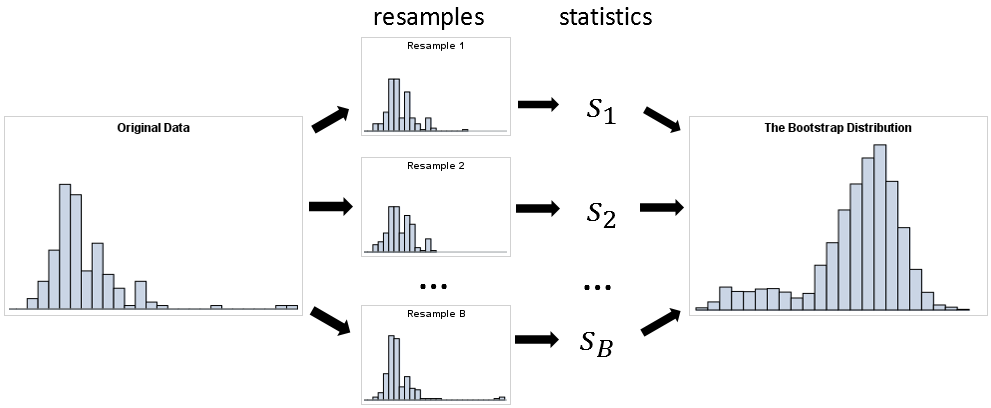

Three stages present in the notebook:
* First, we check what data should be cleaned
* Second, we apply bootstrapping
* Last, estimation is done by use of random forest and extreme boosting

Let's start

# Data cleaning

In [ ]:
# Basic libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from mlxtend.preprocessing import minmax_scaling
import seaborn as sns
import matplotlib.pyplot as plt

# Libraries for bootstrap
from sklearn.utils import resample

# Libraries for estimation
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Pre-defined random state        
RandState = 100

In [ ]:
df_path = '/kaggle/input/heart-failure-clinical-data/heart_failure_clinical_records_dataset.csv'
df = pd.read_csv(df_path)
NoRecords = df.shape[0]

In [ ]:
#df.head()
df.describe()

In [ ]:
C = (df.dtypes == 'object')
CategoricalVariables = list(C[C].index)

print(CategoricalVariables)

Integer = (df.dtypes == 'int64') 
Float   = (df.dtypes == 'float64') 
NumericVariables = list(Integer[Integer].index) + list(Float[Float].index)

print(NumericVariables)

In [ ]:
Missing_Percentage = (df.isnull().sum()).sum()/np.product(df.shape)*100

print("The number of missing entries: " + str(round(Missing_Percentage,10)) + " %")

Alright, the data set is:
* only numeric, all variables are of format integer.float
* very clean, no corrections needed at this stage
Let's jump to bootstrap

# Bootstrap

First, we apply scaling to continous features.

In [ ]:
AllVars = list(df.columns)  
ContVars = ['age','ejection_fraction','creatinine_phosphokinase','platelets','serum_creatinine','serum_sodium','time']
BinVars = [x for x in AllVars if x not in ContVars]
df.index.name = 'Id'

sc_df = df
sc_df[ContVars] = minmax_scaling(df, columns=ContVars)

Now, we will apply bootstrap to our data. We implement our data set as first argument, we allow for replacement and use pre-defined random state. The argument *number of samples* is not trivial. How to choose? Similarly to any train/test set in other topics. Hence, as our number of records is 299, we will chose let's say 80% of them. Will it be really 80%? No, because of resampling, in other words some records may appear twice or more and some records will not appear there for sure.

In [ ]:
boot = resample(sc_df, replace=True, n_samples=round(NoRecords*0.80), random_state=RandState) # 240 ~= 299 * 80%
# boot.describe()

boot_indices_list = list(boot.index)  
boot_indices = pd.DataFrame(boot.index)  

# out of bag observations
oob = sc_df[~sc_df.index.isin(boot_indices_list)]
print('The number of records in bootstrap sample is: ' + format(boot.shape[0]) + '. The number of records in out-of-bag sample is: ' + format(oob.shape[0]))

For this random seed, we have even 130 out-of-bag records, what means that in total 130 records did not appear in our bootstrap sample. Let's investigate how many records appear more than once.

In [ ]:
boot_indices_agg = boot_indices.groupby('Id').Id.count()

(unique, counts) = np.unique(boot_indices_agg, return_counts=True)

boot_indices_agg = pd.DataFrame(np.asarray((unique, counts)).T, columns = ['Value','Frequency'])

boot_indices_agg.plot(kind='bar',x='Value',y='Frequency')

Some values appear even 4 times. This explains why oob set can be so big. Alright, we managed to make bootstrapping once. However, the base of this method is repetittion of the procedure many times. Let's do it then, for this it will be much easier to make a function, our function will calculate the number of dead patients is the train & test samples. But as these numbers do not tell us a lot (in their nominal form). We will define the ratio: dead patients/ all patients in sample

In [ ]:
def BootstrapRatio(Data, F): # Data for our data set, F for the size of sample
    BootSet = resample(Data, replace=True, n_samples=round(NoRecords*F))
    DeadBoot = BootSet.loc[BootSet.DEATH_EVENT == 1].shape[0] 
    DeadBootRatio = DeadBoot/BootSet.shape[0]
    OobSet = Data[~Data.index.isin(list(BootSet.index))]
    DeadOob = OobSet.loc[OobSet.DEATH_EVENT == 1].shape[0]
    DeadOobRatio = DeadOob/OobSet.shape[0]
    
    return DeadBootRatio, DeadOobRatio

In [ ]:
B = 101 # How many runs - 1, so 100 runs

B_results = pd.DataFrame(index=range(1,B), columns=['DeathsBoot','DeathsOob'])

for i in range(1,B):
    B_results.DeathsBoot[i],B_results.DeathsOob[i] = BootstrapRatio(sc_df,0.8)
    
B_results

In [ ]:
print('The diff is: '+format(round(B_results.DeathsBoot.mean() - B_results.DeathsOob.mean(),3)))

We have 100 records, and each of them corresponds to separate sample withdrawn from basic data set. Our evaluation for this simple statistic is the difference between mean in-sample and out-of-sample ratios.

But wait, let's make it more interesting: **we will check how the increasing number of sample influences these general means.**

In [ ]:
B_1 = 501 # How many runs - 1, so 500 runs

B_1_results = pd.DataFrame(index=range(1,B_1), columns=['DeathsBoot','DeathsOob','DeathsBootAvg','DeathsOobAvg'])

for i in range(1,B_1):
    B_1_results.DeathsBoot[i],B_1_results.DeathsOob[i] = BootstrapRatio(sc_df,0.8)
    B_1_results.DeathsBootAvg[i]=B_1_results.DeathsBoot.mean()
    B_1_results.DeathsOobAvg[i]=B_1_results.DeathsOob.mean()
    
B_1_results

In [ ]:
sns.distplot(a=B_1_results['DeathsBoot'], hist=False, rug=True, label="Deaths Boot")
sns.distplot(a=B_1_results['DeathsOob'], hist=False, rug=True, label="Deaths Oob")
plt.legend();

In [ ]:
# sns.regplot(data = B_1_results.reset_index(), x = 'index', y = 'DeathsBoot', fit_reg=False, label="Deaths Boot")
# sns.regplot(data = B_1_results.reset_index(), x = 'index', y = 'DeathsOob', fit_reg=False, label="Deaths Oob")

sns.regplot(data = B_1_results.reset_index(), x = 'index', y = 'DeathsBootAvg', fit_reg=False, label="Deaths Boot Avg")
sns.regplot(data = B_1_results.reset_index(), x = 'index', y = 'DeathsOobAvg', fit_reg=False, label="Deaths Oob Avg")

Between 0 and 30 long-term average is very unstable. Further around 50th run it crosses and remains stable. Basically after 300th average, there is no relevant difference. This simple process showed us how in general bootstrap can be useful to estimate any statistic like mean or variance. However, it was not very useful regarding the prediction of heart failure. For this task, we have to change approach a bit. As our target is binary, we will use logistic regression in our random forest model. 

# Estimation
We will use what was learnt from bootstrap analysis to find parameters and the confidence intervals. First, we change a bit the function for bootstrap and implement random forest in it.

In [ ]:
RF = DecisionTreeClassifier()

def BootstrapRandomForest(Data, F, Target): # Data for our data set, F for the size of sample
    BootSet = resample(Data, replace=True, n_samples=round(NoRecords*F))
    OobSet = Data[~Data.index.isin(list(BootSet.index))]
    RF.fit(BootSet.drop(columns=[Target]), BootSet[Target])
    predictions = RF.predict(OobSet.drop(columns=[Target]))
    score = accuracy_score(OobSet[Target], predictions)
    
    return score

In [ ]:
B_2 = 1001 # How many runs - 1, so 1000 runs

B_2_results = pd.DataFrame(index=range(1,B_2), columns=['ScoreRF','ScoreXgb'])

for i in range(1,B_2):
    B_2_results.ScoreRF[i] = BootstrapRandomForest(sc_df,0.8,'DEATH_EVENT')
    
B_2_results

We fitted 1000 random forests and calculated accuracy scores for them. The histogram for our scores is achievable below.

In [ ]:
sns.distplot(B_2_results['ScoreRF'], color="g").set_title("Accuracy scores for random forest (bootstrapping method)", color="g")

Following the histogram, the confidence intervals below. How to understand it? There is 95% likelihood that the confidence interval ~70% and ~83% cover the true skill of the model.

In [ ]:
alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower = max(0.0, np.percentile(B_2_results['ScoreRF'], p))
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = min(1.0, np.percentile(B_2_results['ScoreRF'], p))
print('%.1f confidence interval %.1f%% and %.1f%%' % (alpha*100, lower*100, upper*100))

Let's check it for extreme boosting as well.

In [ ]:
Xgb =XGBClassifier( booster='gbtree',
             importance_type='gain', learning_rate=0.01,
             max_depth=4, min_child_weight=1.5, n_estimators=500, objective='binary:logistic')

def BootstrapXgb(Data, F, Target): # Data for our data set, F for the size of sample
    BootSet = resample(Data, replace=True, n_samples=round(NoRecords*F))
    OobSet = Data[~Data.index.isin(list(BootSet.index))]
    Xgb.fit(BootSet.drop(columns=[Target]), BootSet[Target])
    predictions = Xgb.predict(OobSet.drop(columns=[Target]))
    score = accuracy_score(OobSet[Target], predictions)
    
    return score

for i in range(1,B_2):
    B_2_results.ScoreXgb[i] = BootstrapXgb(sc_df,0.8,'DEATH_EVENT')
    
B_2_results

In [ ]:
sns.distplot(B_2_results['ScoreXgb'], color="g").set_title("Accuracy scores for extreme boosting (bootstrapping method)", color="g")

In [ ]:
alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower = max(0.0, np.percentile(B_2_results['ScoreXgb'], p))
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = min(1.0, np.percentile(B_2_results['ScoreXgb'], p))
print('%.1f confidence interval %.1f%% and %.1f%%' % (alpha*100, lower*100, upper*100))

In [ ]:
sns.distplot(a=B_2_results['ScoreRF'], hist=False, rug=True, label="Accuracy Random Forest")
sns.distplot(a=B_2_results['ScoreXgb'], hist=False, rug=True, label="Accuracy Extreme boosting")
plt.legend();

**The above graph presents how extreme boosting outperforms random forest and is more informative than alone statistic regarding the model comparison. In that way bootstrap allows for broader methods' comparison.**